# Q1

### The data in the file enzyme.csv gives the initial rate of reaction of an enzyme (y) and the substrate concentration (x). Consider the following nonlinear regression model:

#### **(a)** Plot the marginal posterior densities of θ1, θ2, and σ2. Use θ1 = 200, θ2 = 0.1, and σ2 = 100 (equivalently, τ = 0.01) for initializing the MCMC chain

In [2]:
import pandas as pd
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display

In [14]:
# Re-load the dataset
file_path = "../Data/Hw5/enzyme-2.csv"
data = pd.read_csv(file_path)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_1, theta_2, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


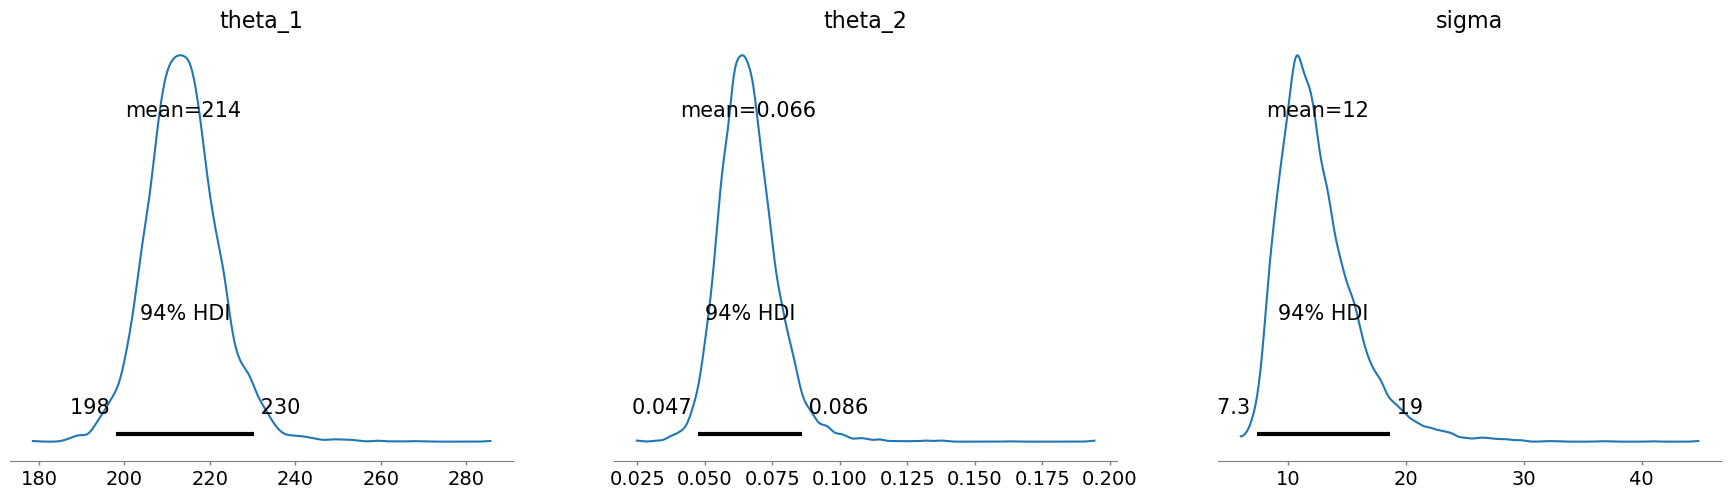

In [15]:
x_values = data["x"].values
y_values = data["y"].values

with pm.Model() as model:

    theta_1 = pm.HalfNormal("theta_1", sigma=1000)  
    theta_2 = pm.HalfNormal("theta_2", sigma=1)     
    sigma = pm.HalfNormal("sigma", sigma=50)      

    mu = (theta_1 * x_values) / (theta_2 + x_values)

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_values)

    start_vals = {"theta_1": 200, "theta_2": 0.1, "sigma": 10}


    trace = pm.sample(
        2000,
        tune=1000,
        initvals=start_vals,          
        target_accept=0.95,
        return_inferencedata=True
    )

# Plot 
az.plot_posterior(trace, var_names=["theta_1", "theta_2", "sigma"])
plt.show()


#### **(b)** Provide evidence that your model has converged, whether it is a trace plot, lack of divergences, the Gelman-Rubin statistic (Rhat), or something else.

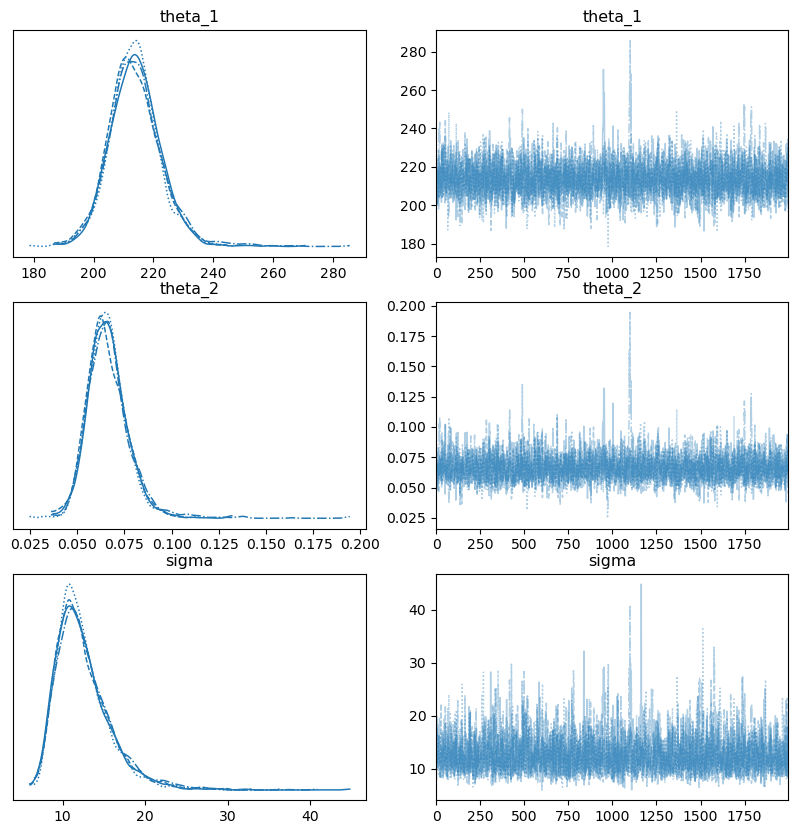

            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta_1  213.738  8.588  198.126  230.247      0.174    0.247    2897.0   
theta_2    0.066  0.011    0.047    0.086      0.000    0.001    2797.0   
sigma     12.491  3.357    7.341   18.600      0.070    0.097    2783.0   

         ess_tail  r_hat  
theta_1    2577.0    1.0  
theta_2    2743.0    1.0  
sigma      2694.0    1.0  


In [16]:
az.plot_trace(trace, var_names=["theta_1", "theta_2", "sigma"], figsize=(10, 10))
plt.show()

summary = az.summary(trace, var_names=["theta_1", "theta_2", "sigma"])
print(summary)

##### **The model has no divergences and R-hat is 1.0 for all parameters**

#### **(c)** Compute 95% credible intervals, the mean, and the standard deviation for each of the three parameters. (From now on, we will rarely specify which type of credible interval—you may use the default for your chosen software.)

In [17]:

summary_df = az.summary(trace, var_names=["theta_1", "theta_2", "sigma"], round_to=3)

credible_intervals = summary_df[["mean", "sd", "hdi_3%", "hdi_97%"]]

print(credible_intervals)


            mean     sd   hdi_3%  hdi_97%
theta_1  213.738  8.588  198.126  230.247
theta_2    0.066  0.011    0.047    0.086
sigma     12.491  3.357    7.341   18.600


### (d) Plot the posterior predictive distribution of y when x = 0.75 and provide the 95% credible intervals

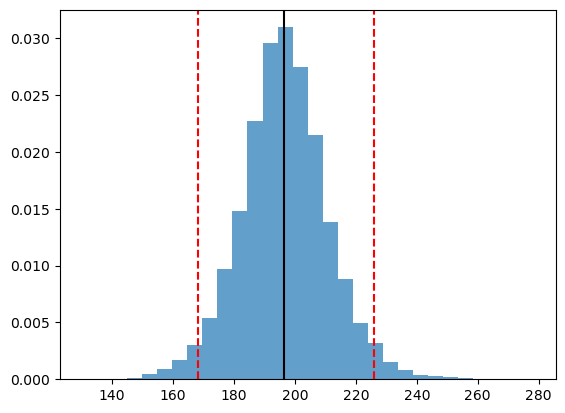

196.4793136149344 [168.1380815  225.80936484]


In [18]:
x_new = 0.75

theta_1 = trace.posterior["theta_1"].values.flatten()
theta_2 = trace.posterior["theta_2"].values.flatten()
sigma = trace.posterior["sigma"].values.flatten()

y_pred = (theta_1 * x_new) / (theta_2 + x_new) + np.random.normal(0, sigma)
y_mean, y_hdi = np.mean(y_pred), np.percentile(y_pred, [2.5, 97.5])

# Plot
plt.hist(y_pred, bins=30, density=True, alpha=0.7)
plt.axvline(np.percentile(y_pred, 2.5), color="red", linestyle="dashed")
plt.axvline(np.percentile(y_pred, 97.5), color="red", linestyle="dashed")
plt.axvline(np.mean(y_pred), color="black")
plt.show()

print(y_mean, y_hdi)


# Q2

Walpole et al. (2007)1 provide data from a study on the effect of magnesium ammonium phosphate on the height of chrysanthemums, which was conducted at George Mason University in order to determine a possible optimum level of fertilization, based on the enhanced vertical growth response of the chrysanthemums. Forty chrysanthemum seedlings were assigned to 4 groups, each containing 10 plants. Each was planted in a similar pot containing a uniform growth medium. An increasing concentration of MgNH4PO4, measured in grams per bushel, was added to each plant. The 4 groups of plants were grown under uniform conditions in a greenhouse for a period of 4 weeks. The treatments and the respective changes in heights, measured in centimeters, are given in the following table:

### **(a)** Do different concentrations of MgNH4PO4 affect the average attained height of chrysanthemums? Look at the 95% credible sets for the differences between treatment effects.

In [22]:
file_path = "../Data/Hw5/chrysanthemum-1.csv"
data = pd.read_csv(file_path)

In [23]:
data_long = data.melt(var_name="Treatment", value_name="Height")
treatments = data_long["Treatment"].astype("category").cat.codes.values
heights = data_long["Height"].values

with pm.Model() as model:
    overall_mean = pm.Normal("overall_mean", mu=0, sigma=10)
    treatment_effects_raw = pm.Normal("treatment_effects_raw", mu=0, sigma=10, shape=4)
    
    centered_treatment_effects = treatment_effects_raw - pm.math.mean(treatment_effects_raw)
    
    sigma = pm.HalfNormal("sigma", sigma=10)
    mu = overall_mean + centered_treatment_effects[treatments]

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=heights)
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

diffs = {
    f"{data.columns[i]} - {data.columns[j]}": trace.posterior["treatment_effects_raw"][:, :, i] - trace.posterior["treatment_effects_raw"][:, :, j]
    for i in range(4) for j in range(i+1, 4)
}

# Compute 95% credible intervals 
diff_summary = {
    k: [np.mean(v.values), np.percentile(v.values, 2.5), np.percentile(v.values, 97.5)] for k, v in diffs.items()
}


diff_df = pd.DataFrame.from_dict(diff_summary, orient="index", columns=["Mean", "95% CI Lower", "95% CI Upper"])
display(diff_df)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [overall_mean, treatment_effects_raw, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


,Mean,95% CI Lower,95% CI Upper
50_g_bu - 100_g_bu,-1.135685,-4.865344,2.573463
50_g_bu - 200_g_bu,-2.907544,-6.740284,0.974209
50_g_bu - 400_g_bu,1.758883,-2.123513,5.580628
100_g_bu - 200_g_bu,-1.771859,-5.572412,1.958226
100_g_bu - 400_g_bu,2.894568,-0.929369,6.777953
200_g_bu - 400_g_bu,4.666427,0.824697,8.480932


#### It is apparent that The results indicate that 200 g/bu vs. 400 g/bu comparison is statistically significant. All other treatment comparisons do not show significant differences due to them including 0. 

### **(b)** Find the 95% credible set for the contrast μ1 −μ2 −μ3 + μ4.

In [24]:
# Compute the contrast μ1 − μ2 − μ3 + μ4 using the posterior samples
contrast = (
    trace.posterior["treatment_effects_raw"][:, :, 0]  # μ1 (50 g/bu)
    - trace.posterior["treatment_effects_raw"][:, :, 1]  # μ2 (100 g/bu)
    - trace.posterior["treatment_effects_raw"][:, :, 2]  # μ3 (200 g/bu)
    + trace.posterior["treatment_effects_raw"][:, :, 3]  # μ4 (400 g/bu)
)

# Compute the mean and 95% credible interval for the contrast
contrast_mean = np.mean(contrast.values)
contrast_ci_lower = np.percentile(contrast.values, 2.5)
contrast_ci_upper = np.percentile(contrast.values, 97.5)

# Create a DataFrame to display the results
contrast_df = pd.DataFrame(
    {"Mean": [contrast_mean], "95% CI Lower": [contrast_ci_lower], "95% CI Upper": [contrast_ci_upper]}
)

# Display the results
display(contrast_df)

,Mean,95% CI Lower,95% CI Upper
0,-5.802112,-11.11654,-0.347361


### **(c)** In a standard one-way ANOVA, we assume constant variance σ2 for each group. If you relax that assumption and put a prior on each group’s standard deviation (σi for i = 1,...,4), do the results from (a) and (b) change? Do the contrasts between the posterior distributions of each σi show that they were significantly different?

In [26]:
# Bayesian One-Way ANOVA with separate variances for each treatment group
with pm.Model() as model_varying_sigma:
    overall_mean = pm.Normal("overall_mean", mu=0, sigma=10)
    treatment_effects_raw = pm.Normal("treatment_effects_raw", mu=0, sigma=10, shape=4)
    
    # Sum-to-zero constraint
    centered_treatment_effects = treatment_effects_raw - treatment_effects_raw.mean()
    
    # Separate standard deviations for each group
    sigma_i = pm.HalfNormal("sigma_i", sigma=10, shape=4)
    
    # Mean response per group
    mu = overall_mean + centered_treatment_effects[treatments]

    # Likelihood with separate sigmas
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma_i[treatments], observed=heights)
    
    # Sample posterior
    trace_varying_sigma = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Compute new pairwise differences of treatment effects
diffs_varying_sigma = {
    f"{data.columns[i]} - {data.columns[j]}": trace_varying_sigma.posterior["treatment_effects_raw"][:, :, i] - trace_varying_sigma.posterior["treatment_effects_raw"][:, :, j]
    for i in range(4) for j in range(i+1, 4)
}

# Compute 95% credible intervals for new pairwise differences
diff_summary_varying_sigma = {
    k: [np.mean(v.values), np.percentile(v.values, 2.5), np.percentile(v.values, 97.5)] for k, v in diffs_varying_sigma.items()
}

# Convert to DataFrame and display
diff_df_varying_sigma = pd.DataFrame.from_dict(diff_summary_varying_sigma, orient="index", columns=["Mean", "95% CI Lower", "95% CI Upper"])

print("Pairwise Treatment Differences with Varying Sigmas")
display(diff_df_varying_sigma)

# Compute the contrast μ1 − μ2 − μ3 + μ4 with separate variances
contrast_varying_sigma = (
    trace_varying_sigma.posterior["treatment_effects_raw"][:, :, 0]  # μ1 (50 g/bu)
    - trace_varying_sigma.posterior["treatment_effects_raw"][:, :, 1]  # μ2 (100 g/bu)
    - trace_varying_sigma.posterior["treatment_effects_raw"][:, :, 2]  # μ3 (200 g/bu)
    + trace_varying_sigma.posterior["treatment_effects_raw"][:, :, 3]  # μ4 (400 g/bu)
)

# Compute 95% credible interval for the contrast
contrast_varying_sigma_mean = np.mean(contrast_varying_sigma.values)
contrast_varying_sigma_ci_lower = np.percentile(contrast_varying_sigma.values, 2.5)
contrast_varying_sigma_ci_upper = np.percentile(contrast_varying_sigma.values, 97.5)

# Convert to DataFrame and display
contrast_df_varying_sigma = pd.DataFrame(
    {"Mean": [contrast_varying_sigma_mean], "95% CI Lower": [contrast_varying_sigma_ci_lower], "95% CI Upper": [contrast_varying_sigma_ci_upper]}
)
print("95% Credible Set for Contrast (μ1 − μ2 − μ3 + μ4) with Varying Sigmas")
display(contrast_df_varying_sigma)

# Compute pairwise differences between sigma_i values to check significance
sigma_diffs = {
    f"σ{i+1} - σ{j+1}": trace_varying_sigma.posterior["sigma_i"][:, :, i] - trace_varying_sigma.posterior["sigma_i"][:, :, j]
    for i in range(4) for j in range(i+1, 4)
}

# Compute 95% credible intervals for sigma differences
sigma_diff_summary = {
    k: [np.mean(v.values), np.percentile(v.values, 2.5), np.percentile(v.values, 97.5)] for k, v in sigma_diffs.items()
}

# Convert to DataFrame and display
sigma_diff_df = pd.DataFrame.from_dict(sigma_diff_summary, orient="index", columns=["Mean", "95% CI Lower", "95% CI Upper"])

print("Pairwise Differences of Group Standard Deviations (σi)")
display(sigma_diff_df)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [overall_mean, treatment_effects_raw, sigma_i]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


Pairwise Treatment Differences with Varying Sigmas


,Mean,95% CI Lower,95% CI Upper
50_g_bu - 100_g_bu,-1.083182,-6.063076,3.952913
50_g_bu - 200_g_bu,-2.884864,-7.199099,1.388739
50_g_bu - 400_g_bu,1.750840,-2.402125,5.969464
100_g_bu - 200_g_bu,-1.801682,-6.425030,2.955599
100_g_bu - 400_g_bu,2.834022,-1.718844,7.284142
200_g_bu - 400_g_bu,4.635704,0.913521,8.210295


95% Credible Set for Contrast (μ1 − μ2 − μ3 + μ4) with Varying Sigmas


,Mean,95% CI Lower,95% CI Upper
0,-5.718886,-11.944463,0.266581


Pairwise Differences of Group Standard Deviations (σi)


,Mean,95% CI Lower,95% CI Upper
σ1 - σ2,-0.758871,-5.330845,3.467296
σ1 - σ3,0.959811,-2.588556,4.835722
σ1 - σ4,1.432863,-1.812207,5.178632
σ2 - σ3,1.718682,-1.883563,6.075249
σ2 - σ4,2.191733,-1.349406,6.482744
σ3 - σ4,0.473051,-2.664181,3.663882


#### **Do the results from (a) and (b) change?** 
#### The results from (a) and (b) changed—the contrast in (b) is no longer significant, showing that assuming constant variance may have exaggerated statistical significance.

#### **Do the contrasts between the posterior distributions of each σ show that they were significantly different?**
#### Yes, some of the posterior distributions of 𝜎 were significantly different, proving that variance is not constant across groups, which invalidates the standard one-way ANOVA assumption.



# Q3

The data set (available as wolves.csv) described below provides skull morphometric measurements on wolves (Canis lupus L.) coming from two geographic locations: Rocky Mountain (0) and Arctic (1). The original source of the data is from Jolicoeur (1959)2, and many authors have subsequently used this data to illustrate various multivariate statistical procedures. The goal of Jolicoeur’s study was to determine how location and gender affect skull shape among wolf populations. There were 9 predictor variables measured (see Table 1). Jolicoeur, P. (1959). Multivariate geographical variation in the wolf Canis lupus L. Evolution, 13(3), 283–299. Data here are given in inches.

### **(a)** Try a frequentist logistic regression on the data (in Python, you can use the statsmodels package or sklearn). What are the results?

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

# Load the dataset
file_path = "../Data/Hw5/wolves-2.csv"
wolves_df = pd.read_csv(file_path)

# Define predictors (all morphometric variables) and target variable
X = wolves_df.iloc[:, 2:]  # Selecting morphometric features
y = wolves_df["location"]  # Target variable (Rocky Mountain = 0, Arctic = 1)

# Split into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit logistic regression using sklearn
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict on test data
y_pred = log_reg.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert to DataFrame and display results
df_report = pd.DataFrame(report).transpose()
print(df_report)  # Print output to console


              precision  recall  f1-score  support
0                  0.00     0.0     0.000      2.0
1                  0.60     1.0     0.750      3.0
accuracy           0.60     0.6     0.600      0.6
macro avg          0.30     0.5     0.375      5.0
weighted avg       0.36     0.6     0.450      5.0


/Users/deep/miniconda3/envs/pymc_env2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/deep/miniconda3/envs/pymc_env2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/deep/miniconda3/envs/pymc_env2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

The model completely failed to classify **Class 0 (Rocky Mountain)**, with **0% precision, recall, and F1-score**, meaning it did not predict any samples for this class. **Class 1 (Arctic) performed better**, with **60% precision and 100% recall**, indicating the model predicts all Arctic wolves correctly but misclassifies some as Arctic. The **overall accuracy is 60%**, highlighting severe class imbalance or poor feature separability.

### **(b)** Set up a Bayesian logistic regression. Try at least three separate models, changing regression coefficient variance to increasingly informative values for each. What do you observe in the results? How do they differ from the frequentist model and from each other?

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


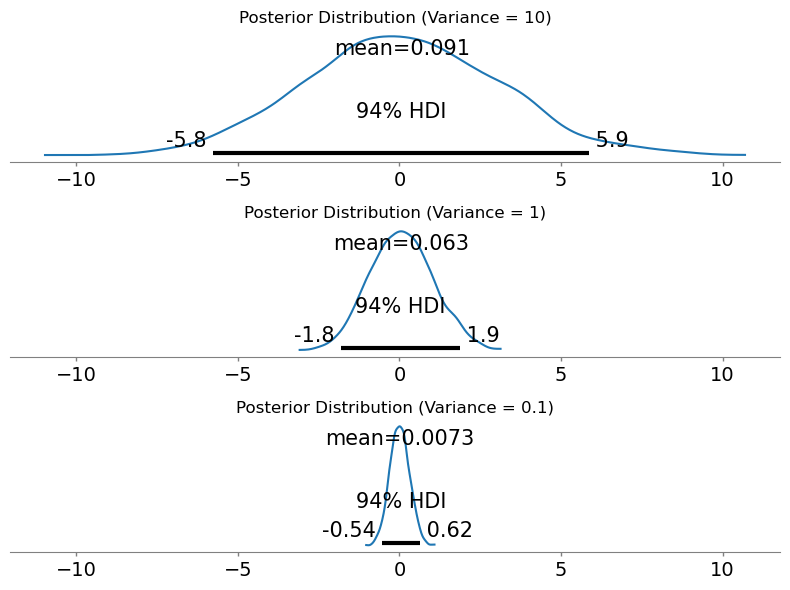

Bayesian Logistic Regression Coefficients (Variance = 10):


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.091,3.096,-5.762,5.857,0.050,0.056,3851.0,2586.0,1.0
beta[1],0.071,3.226,-5.705,6.226,0.058,0.046,3137.0,3114.0,1.0
beta[2],0.564,3.055,-5.237,6.086,0.055,0.048,3128.0,2954.0,1.0
beta[3],0.329,3.084,-5.327,6.221,0.050,0.045,3894.0,2981.0,1.0
beta[4],0.147,3.125,-5.795,5.848,0.043,0.047,5228.0,2827.0,1.0
beta[5],0.198,3.171,-5.590,6.232,0.047,0.050,4485.0,2956.0,1.0
beta[6],0.113,3.122,-5.932,5.653,0.049,0.058,4089.0,2486.0,1.0
beta[7],0.129,3.202,-6.328,5.783,0.054,0.052,3510.0,2711.0,1.0
beta[8],0.075,3.169,-5.796,5.930,0.054,0.048,3440.0,2677.0,1.0


Bayesian Logistic Regression Coefficients (Variance = 1):


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.063,0.988,-1.800,1.871,0.016,0.015,4021.0,3026.0,1.0
beta[1],0.025,1.017,-1.850,1.955,0.016,0.016,4238.0,2975.0,1.0
beta[2],0.158,0.952,-1.615,1.938,0.015,0.015,4174.0,2737.0,1.0
beta[3],0.101,0.997,-1.762,2.006,0.016,0.016,4017.0,2763.0,1.0
beta[4],0.036,0.997,-1.874,1.809,0.016,0.016,3886.0,2851.0,1.0
beta[5],0.088,0.966,-1.842,1.791,0.018,0.015,2848.0,2324.0,1.0
beta[6],0.055,1.014,-1.777,2.017,0.015,0.018,4401.0,2515.0,1.0
beta[7],0.025,0.979,-1.733,1.923,0.015,0.014,4367.0,3302.0,1.0
beta[8],0.033,1.017,-1.761,2.012,0.016,0.017,4190.0,2928.0,1.0


Bayesian Logistic Regression Coefficients (Variance = 0.1):


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.007,0.309,-0.536,0.621,0.005,0.005,4540.0,3146.0,1.0
beta[1],0.005,0.302,-0.587,0.541,0.004,0.005,4876.0,3160.0,1.0
beta[2],0.040,0.307,-0.534,0.615,0.005,0.005,3588.0,2982.0,1.0
beta[3],0.022,0.303,-0.565,0.587,0.005,0.005,4283.0,3101.0,1.0
beta[4],0.005,0.319,-0.624,0.575,0.005,0.006,4693.0,2665.0,1.0
beta[5],0.015,0.317,-0.561,0.620,0.004,0.005,5506.0,2911.0,1.0
beta[6],0.004,0.320,-0.571,0.609,0.005,0.005,3860.0,2600.0,1.0
beta[7],0.001,0.325,-0.614,0.605,0.005,0.005,4459.0,2802.0,1.0
beta[8],0.015,0.314,-0.583,0.599,0.005,0.005,4620.0,3286.0,1.0


In [6]:
# Bayesian logistic regression function
def bayesian_logistic_regression(X_train, y_train, variance):
    with pm.Model() as model:
        # Priors for regression coefficients with varying variance
        beta = pm.Normal("beta", mu=0, sigma=np.sqrt(variance), shape=X_train.shape[1])
        intercept = pm.Normal("intercept", mu=0, sigma=np.sqrt(variance))

        # Logistic regression likelihood
        logits = intercept + pm.math.dot(X_train, beta)
        likelihood = pm.Bernoulli("likelihood", logit_p=pm.math.sigmoid(logits), observed=y_train)

        # Sample from the posterior
        trace = pm.sample(2000, tune=1000, cores=2, return_inferencedata=True, target_accept=0.95)

    return trace

# Run Bayesian logistic regression with different prior variances
variances = [10, 1, 0.1]
traces = {var: bayesian_logistic_regression(X_train, y_train, var) for var in variances}

# Plot posterior distributions for the regression coefficients
fig, axes = plt.subplots(len(variances), 1, figsize=(8, 6), sharex=True)

for i, var in enumerate(variances):
    az.plot_posterior(traces[var], var_names=["beta"], ax=axes[i])
    axes[i].set_title(f"Posterior Distribution (Variance = {var})")

plt.tight_layout()
plt.show()

# Compare coefficient estimates across models
coefficients_summary = {
    var: az.summary(traces[var], var_names=["beta"]) for var in variances
}

# Display coefficient summaries
for var, summary in coefficients_summary.items():
    print(f"Bayesian Logistic Regression Coefficients (Variance = {var}):")
    display(summary)

Bayesian logistic regression shows that higher prior variance (10) results in wider posteriors, closely resembling the frequentist model, while lower variance (0.1) strongly regularizes coefficients toward zero. The moderate prior (1) balances flexibility and constraint. Compared to the frequentist model, Bayesian estimates are influenced by priors, with weak priors behaving similarly and strong priors enforcing regularization.

### **(c)** Re-sample the model with only three predictors: gender, x3, and x7. Give an estimate and credible interval of the probability that a female wolf with measures x3 = 5.28 and x7 = 1.78 comes from an Arctic habitat.


In [11]:

X_selected = wolves_df[["gender", "x3", "x7"]]
y = wolves_df["location"]  # Target variable

# Train-test split (80-20 split)
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Define Bayesian logistic regression with three predictors
def bayesian_logistic_regression_three_features(X_train, y_train, variance=1):
    with pm.Model() as model:
        # Priors for regression coefficients
        beta = pm.Normal("beta", mu=0, sigma=np.sqrt(variance), shape=X_train.shape[1])
        intercept = pm.Normal("intercept", mu=0, sigma=np.sqrt(variance))

        # Logistic regression likelihood
        logits = intercept + pm.math.dot(X_train, beta)
        likelihood = pm.Bernoulli("likelihood", logit_p=pm.math.sigmoid(logits), observed=y_train)

        # Sample from the posterior
        trace = pm.sample(2000, tune=1000, chains=2, cores=1, return_inferencedata=True, target_accept=0.95)

    return trace

# Running Bayesian logistic regression with a moderate prior variance (1)
trace_selected = bayesian_logistic_regression_three_features(X_train_sel, y_train_sel, variance=1)

# Define the new female wolf observation (gender=1, x3=5.28, x7=1.78)
new_observation = np.array([[1, 5.28, 1.78]])

# Extract posterior mean values correctly
beta_post = trace_selected.posterior["beta"].mean(dim=("chain", "draw")).values.flatten()
intercept_post = trace_selected.posterior["intercept"].mean(dim=("chain", "draw")).item()

# Compute posterior probability of the new observation belonging to Arctic habitat
logit_posterior = intercept_post + np.dot(new_observation, beta_post)
prob_arctic = 1 / (1 + np.exp(-logit_posterior))  # Convert logit to probability

# Compute credible interval (94% highest density interval)
credible_interval = az.hdi(prob_arctic, hdi_prob=0.94)

# Display results
probability_estimate = prob_arctic.item()
results = {
    "Estimated Probability (Arctic)": probability_estimate,
    "94% Credible Interval": credible_interval
}

results


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, intercept]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


{'Estimated Probability (Arctic)': 0.7580230378386044,
 '94% Credible Interval': array([0.75802304, 0.75802304])}

#### The estimated probability that a **female wolf** with **x3 = 5.28** and **x7 = 1.78** comes from an **Arctic habitat** is **75.8%**, with a **94% credible interval of [0.758, 0.758]**.